# Initial envirnoment



In [26]:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np
from tensorflow import keras
import os

try:
  use_cuda = True
except:
  pass  


#test GPU
x = tf.random_uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))


## google drive
from google.colab import drive
drive.mount('/content/drive')

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
False
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## parameters
这是唯一需要修改的地方，所有图片，创建文件夹，数据和模型的保存全是自动实现的

In [0]:
model_name = "MobileNet Model"
epochs = 3
data_path_floder ="my dataset"
# 这三个名字也决定了文件夹存储的目录，一定要小心管理这三个部分。

#image parameters
IMAGE_SHAPE = (224, 224)
validation_split = 0.15
batch_size = 32
classes = 8




In [28]:

'''
建立存储目录
'''
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   
		os.makedirs(path)            
		print ("---  new folder...  ---")
		print ("---  OK  ---")
	else:
		print ("---  There is this folder!  ---")

data_path = "/content/drive/My Drive/datasets/" + data_path_floder +"/"
save_path = "/content/drive/My Drive/model_saving/"+data_path_floder+"/"+model_name+"/epochs="+str(epochs)
mkdir(save_path)


f = open(save_path+"/info.txt", 'w')
f.write("dataset: "+ data_path_floder+"\n"
        "model name: "+ model_name+"\n"
        "training epochs: "+str(epochs)+"\n" )
f.close()


print(data_path)
save_path
path_5h = save_path+"/"+ model_name+"_"+data_path_floder+"_epochs = "+str(epochs)+".h5"
print(path_5h)

---  There is this folder!  ---
/content/drive/My Drive/datasets/my dataset/
/content/drive/My Drive/model_saving/my dataset/MobileNet Model/epochs=3/MobileNet Model_my dataset_epochs = 3.h5


# Dealing Data 


In [29]:

#dataset generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=validation_split)

#traing set
train_data = image_generator.flow_from_directory(str(data_path),
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=batch_size,
                                                 subset = 'training'
                                                )
#testing set
test_data = image_generator.flow_from_directory(str(data_path),
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=batch_size,
                                                 subset = 'validation'
                                                )



print("traing data shape: ",train_data.image_shape)
print("training data batch size: ",train_data.batch_size)
print("trainig data classes number: ",train_data.num_classes)
print("training data samples number: ",train_data.samples,"\n","\n")

print("test data shape: ",test_data.image_shape)
print("test data batch size: ",test_data.batch_size)
print("test data classes number: ",test_data.num_classes)
print("test data sample number: ",test_data.samples)


Found 17196 images belonging to 24 classes.
Found 3026 images belonging to 24 classes.
traing data shape:  (224, 224, 3)
training data batch size:  32
trainig data classes number:  24
training data samples number:  17196 
 

test data shape:  (224, 224, 3)
test data batch size:  32
test data classes number:  24
test data sample number:  3026


# Building MobileNet

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=train_data.image_shape)

model = tf.keras.Sequential([
  feature_extractor_layer,#我们直接把这个layer放在sequential的一层layer里面
  layers.Dense(units = 200,activation='relu'),
  layers.Dense(train_data.num_classes, activation='softmax')    
])

#model.summary()
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

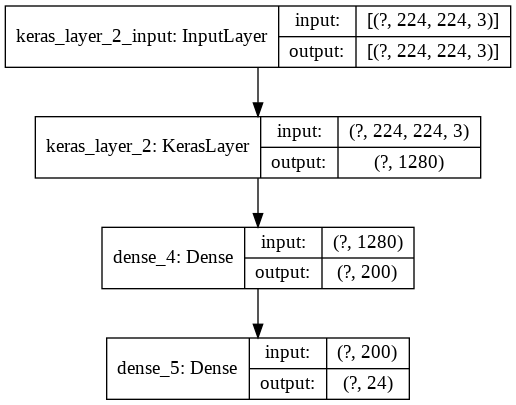

In [32]:
from tensorflow import keras
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

# Fit

In [33]:

#for plot step acc and loss(not bitch just step)
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


#fit
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit(train_data, 
                    epochs=epochs,
                    
                    validation_data = test_data,
                    callbacks = [batch_stats_callback])

Epoch 1/3
538/538 [==============================] - 97s 179ms/step - loss: 0.6267 - acc: 0.8438 - val_loss: 0.4946 - val_acc: 0.8460
Epoch 2/3
538/538 [==============================] - 95s 176ms/step - loss: 0.3756 - acc: 1.0000 - val_loss: 0.4518 - val_acc: 0.8609
Epoch 3/3
538/538 [==============================] - 95s 177ms/step - loss: 0.2894 - acc: 0.9062 - val_loss: 0.4482 - val_acc: 0.8665


#plot 

## plot step acc and loss

---  new folder...  ---
---  OK  ---


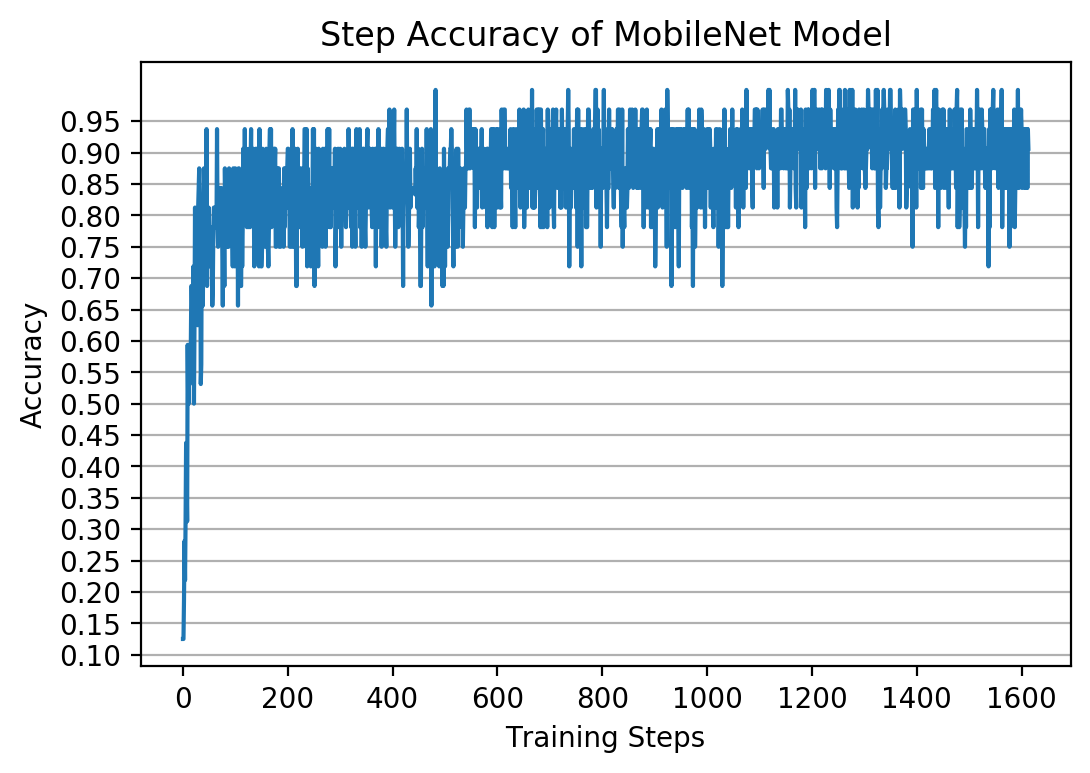

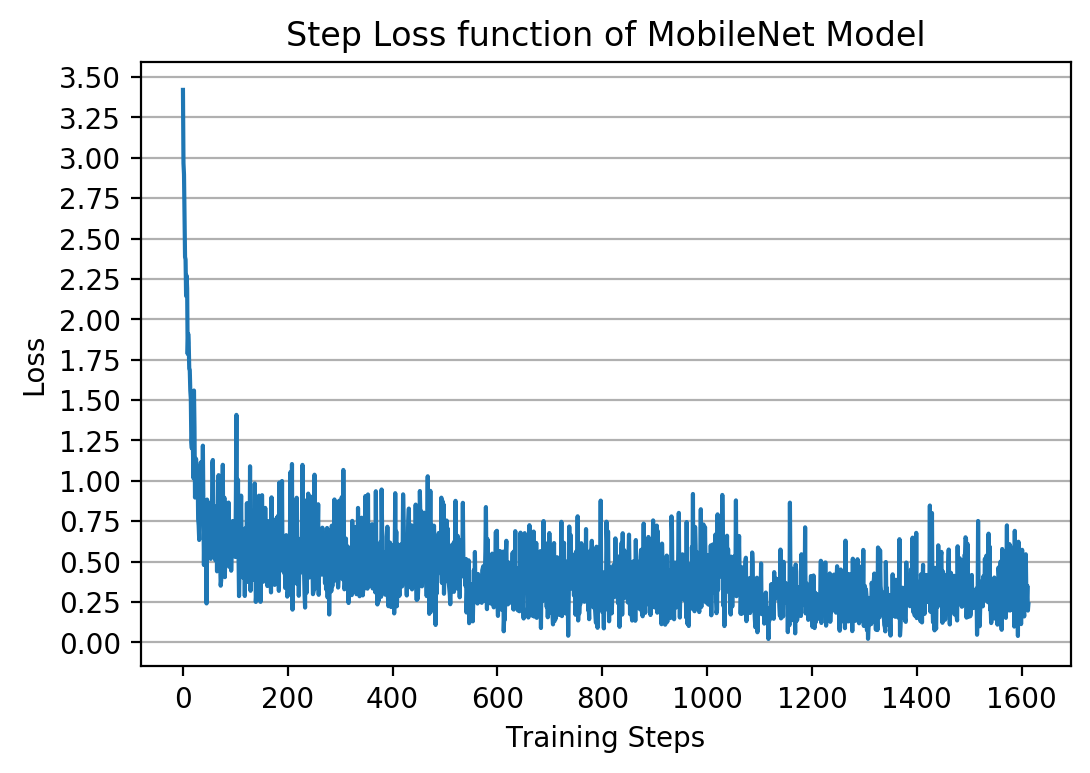

In [34]:
# plot param
title_acc = "Step Accuracy of "+model_name
title_loss = "Step Loss function of "+model_name
figure_path = save_path+"/figures"
mkdir(figure_path)


plt.rcParams['savefig.dpi'] = 200 
plt.rcParams['figure.dpi'] = 200 

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")  
plt.title(title_acc) 
y_ticks = np.arange(0, 1, 0.05)
plt.yticks(y_ticks)          #显示范围为-2至2，每0.2显示一刻度
plt.grid(axis="y")
plt.plot(batch_stats_callback.batch_acc)
fig = plt.gcf()
fig.savefig(figure_path+"/"+title_acc+".png")
plt.show()


plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.title(title_loss) 
y_ticks = np.arange(0, 5, 0.25)
plt.yticks(y_ticks)          #显示范围为-2至2，每0.2显示一刻度
plt.grid(axis="y")
plt.plot(batch_stats_callback.batch_losses)
fig = plt.gcf()
fig.savefig(figure_path+"/"+title_loss+".png")
plt.show()


## plot epoch acc loss and valid acc and valid loss

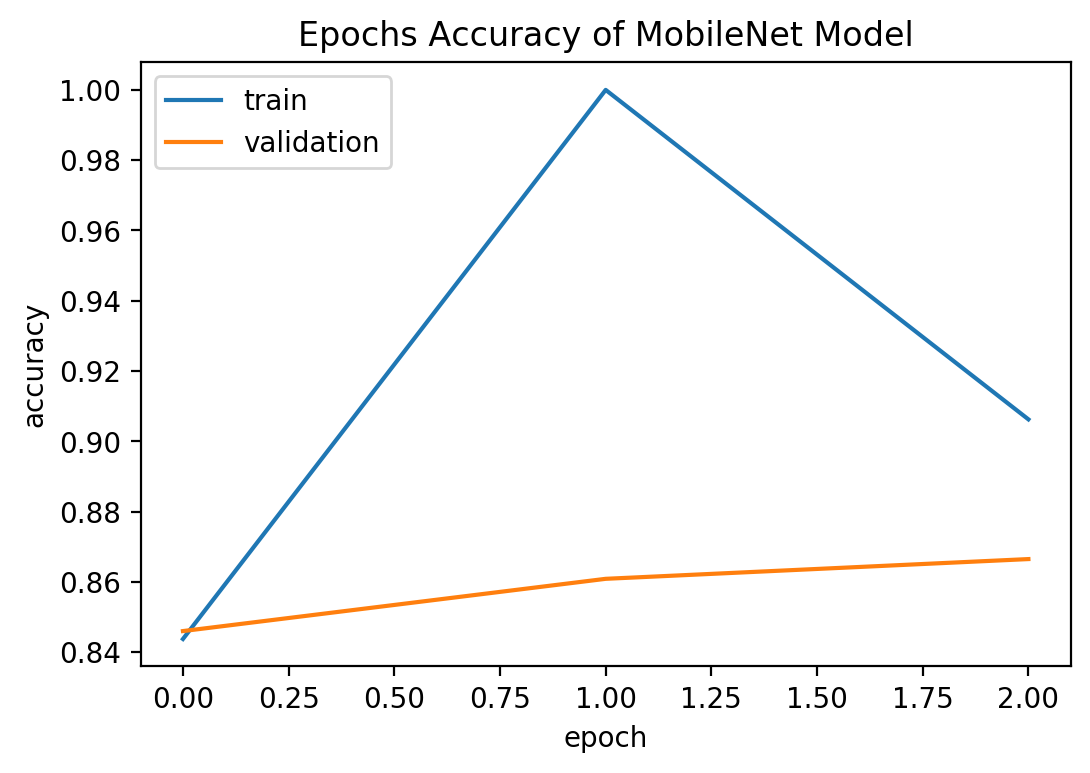

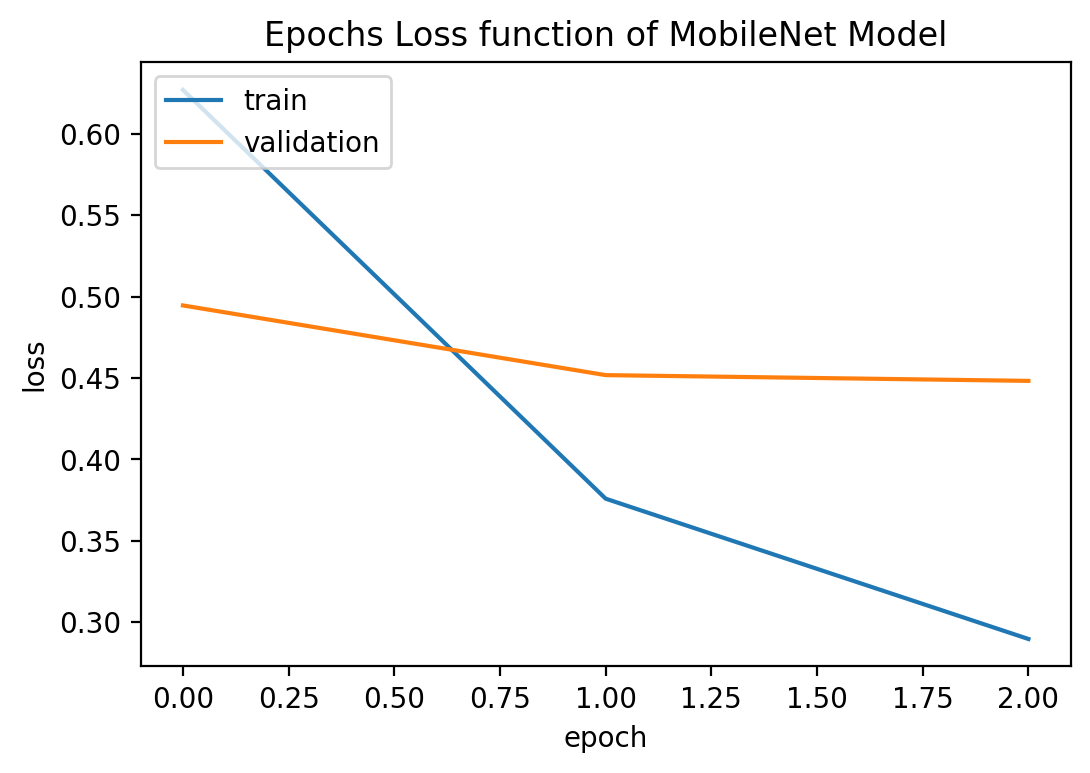

In [35]:
epoch_acc = "Epochs Accuracy of "+model_name
epoch_loss = "Epochs Loss function of "+model_name


# acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title(epoch_acc )
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
fig = plt.gcf()
fig.savefig(figure_path+"/"+epoch_acc+".png")
plt.show()

plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(epoch_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
fig = plt.gcf()
fig.savefig(figure_path+"/"+epoch_loss+".png")
plt.show()

# Evaluation

In [36]:
# evaluat model by test data
loss, acc = model.evaluate(test_data)

95/95 [==============================] - 14s 147ms/step - loss: 0.4492 - acc: 0.8665


# Prediction

## Plot a bitch of prediction result

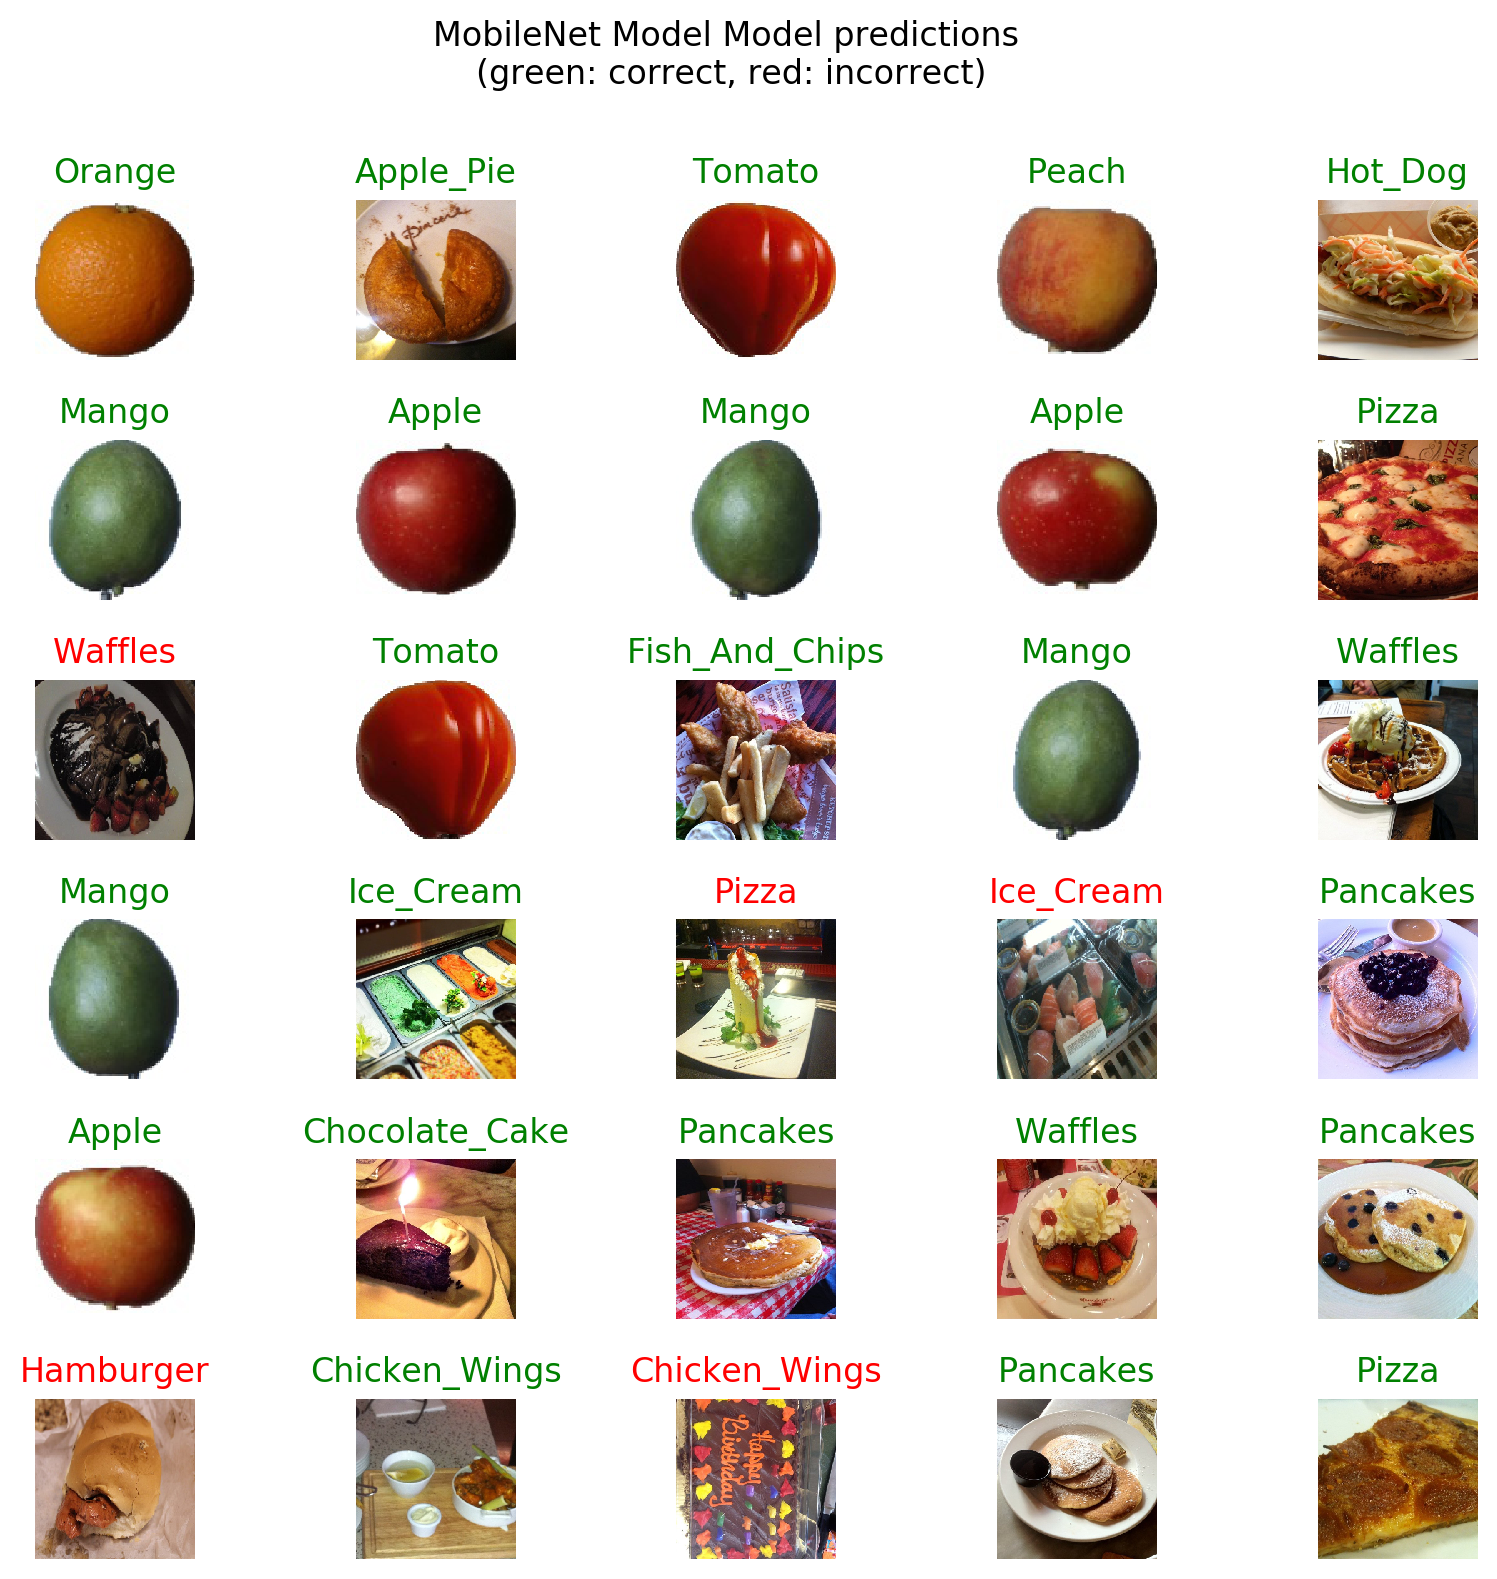

32/32 [==============================] - 0s 873us/sample - loss: 0.7830 - acc: 0.8125
Restored model, accuracy: 81.25%


In [37]:
# pick up a bitch test set
image_test, label_test = test_data.next()


#decode class name from index number 
class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])


predicted_batch = model.predict(image_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_test, axis=-1)


##plot and print out the acc 
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
  plt.suptitle(model_name+" Model predictions \n(green: correct, red: incorrect)")

fig = plt.gcf()
fig.savefig(figure_path+"/"+"demo.png")
plt.show()

loss, acc = model.evaluate(image_test, label_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

##Confusion Matrix

Found 3026 images belonging to 24 classes.
[[147   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  70   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0  73   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  73   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0  71   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   0   0   0   0  72   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0  73   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  66   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  73   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 207   0   

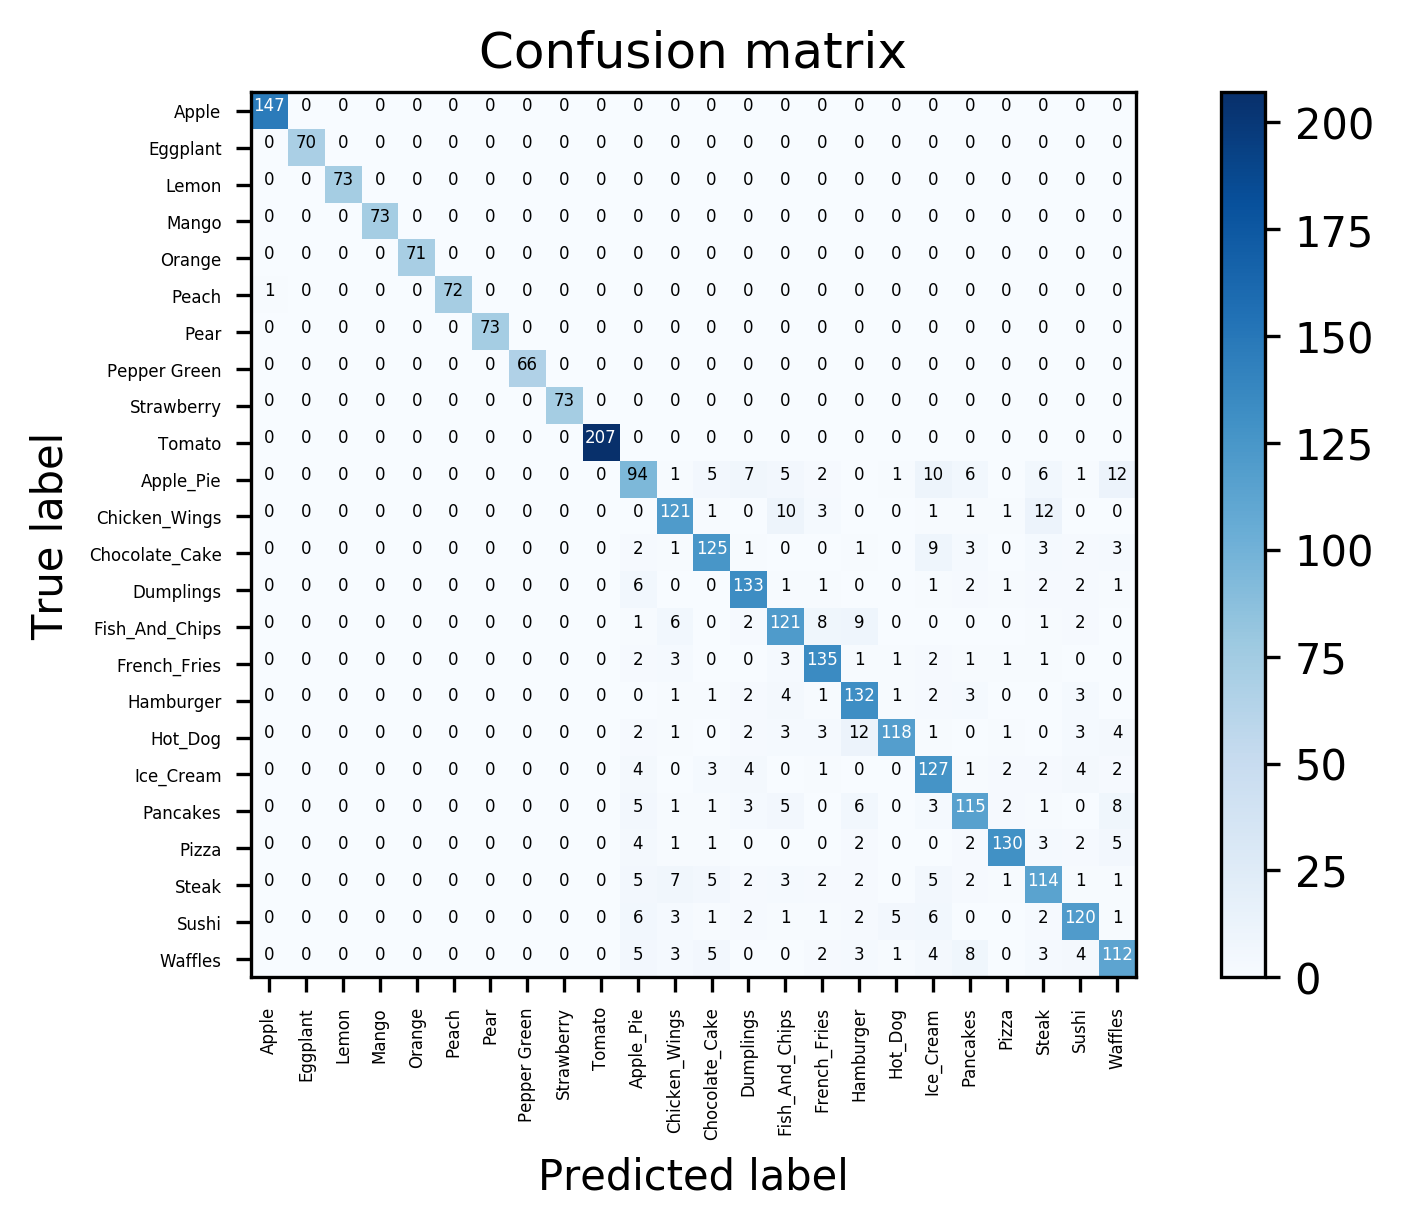

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import itertools


test_data = image_generator.flow_from_directory(str(data_path),
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=batch_size,
                                                 subset = 'validation',
                                                shuffle = False
                                                )

class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])






plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          class_ = 8):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if (class_ == 24):

      size = 4
    else:
      size = 10




    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,size = size)
    plt.yticks(tick_marks, classes,size = size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size = size)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





pred = model.predict(test_data)
pred_index = np.argmax(pred, axis=-1)
cm=tf.math.confusion_matrix(test_data.classes,pred_index)

##convert tensor to np.int32
sess = tf.Session()
with sess.as_default():
  cm_numpy=(cm.eval())

cm_numpy = cm_numpy.astype(np.int16)

##Google lab can not plt it just print out and plot by my own laptop
with tf.Session() as sess:  print(cm.eval()) 
print(class_names)

plot_confusion_matrix(cm_numpy,class_names,class_= train_data.num_classes)
fig = plt.gcf()
fig.savefig(figure_path+"/confusion matrix.png")
plt.show()


# Model saving

## saving h5 model

In [0]:
model.save(path_5h)

### Reload h5

In [0]:
model = tf.keras.models.load_model(path_5h,custom_objects={'KerasLayer':hub.KerasLayer})

## Saving keras model


In [0]:
# import os
# save_path = os.path.abspath("/content/drive/My Drive/model_saving/MobileNet 20 step model/MobileNet_20_steps")
# tf.keras.experimental.export_saved_model(model, save_path)

In [0]:
# reloaded_model = tf.keras.experimental.load_from_saved_model(save_path)